In [ ]:
!pip install recommenders surprise cornac optuna optuna-dashboard nbformat

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

In [ ]:
!cp '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/utils.py' .

In [ ]:
import pandas as pd
import sys
import cornac
import recommenders
import optuna
import surprise

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking

from surprise import Dataset, NormalPredictor, Reader
from utils import compute_ranking_predictions

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/animelist/data_sample_split/'

In [ ]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [ ]:
train_data['updated_at'] = pd.to_datetime(train_data["updated_at"], utc=True)
valid_data['updated_at'] = pd.to_datetime(valid_data["updated_at"], utc=True)

In [ ]:
SEED = 100

## Hyperparameter BPR

In [ ]:
class ObjectiveBPR(object):
    def __init__(self, train_data, valid_data):
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = cornac.data.Dataset.from_uir(self.train_data[['user_id', 'anime_id', 'score']].itertuples(index=False), seed=SEED)

    def __call__(self, trial):

        factors = trial.suggest_int("factors", 20, 200, step=20)
        lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
        lambda_reg = trial.suggest_float("lambda_reg", 1e-3, 1e-1, log=True)
        bpr = cornac.models.BPR(
            k=factors,
            max_iter=20,
            learning_rate=lr,
            lambda_reg=lambda_reg,
            verbose=True,
            seed=SEED
        )
        bpr.fit(self.train_set)
        all_predictions = predict_ranking(bpr, self.train_data, usercol='user_id', itemcol='anime_id', remove_seen=True)
        ndcg_score = ndcg_at_k(self.valid_data, all_predictions, col_user="user_id", col_item="anime_id", col_rating='score', k=10)

        return ndcg_score

In [ ]:
objective = ObjectiveBPR(train_data, valid_data)
study_name = "animelist-bpr"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-08 12:31:32,104] A new study created in RDB with name: animelist-bpr


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-08 12:33:21,014] Trial 1 finished with value: 0.11772876269851916 and parameters: {'factors': 120, 'lr': 0.004670960621926516, 'lambda_reg': 0.002904021202061628}. Best is trial 1 with value: 0.11772876269851916.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-08 12:33:29,675] Trial 0 finished with value: 0.12631028971262862 and parameters: {'factors': 200, 'lr': 0.00548327708111067, 'lambda_reg': 0.001333948977664644}. Best is trial 0 with value: 0.12631028971262862.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-08 12:35:00,184] Trial 2 finished with value: 0.15053207660952736 and parameters: {'factors': 120, 'lr': 0.011531035252429, 'lambda_reg': 0.00875832710891182}. Best is trial 2 with value: 0.15053207660952736.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-08 12:35:00,909] Trial 3 finished with value: 0.113582950863604 and parameters: {'factors': 180, 'lr': 0.0014197294750695362, 'lambda_reg': 0.03618841938188461}. Best is trial 2 with value: 0.15053207660952736.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-08 12:36:24,939] Trial 4 finished with value: 0.18129162496231524 and parameters: {'factors': 120, 'lr': 0.07985554128939053, 'lambda_reg': 0.005699830895736678}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-08 12:36:33,718] Trial 5 finished with value: 0.14793430725900378 and parameters: {'factors': 120, 'lr': 0.00964494067837834, 'lambda_reg': 0.00327917514430065}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-08 12:37:51,612] Trial 6 finished with value: 0.1560958030457846 and parameters: {'factors': 120, 'lr': 0.0483151982612781, 'lambda_reg': 0.03793506808681223}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-08 12:38:00,277] Trial 7 finished with value: 0.11357860574073368 and parameters: {'factors': 140, 'lr': 0.0022232047925226646, 'lambda_reg': 0.004287378549335786}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-08 12:39:17,335] Trial 8 finished with value: 0.11311332775973294 and parameters: {'factors': 200, 'lr': 0.00270160821083181, 'lambda_reg': 0.006520082778575563}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:39:31,696] Trial 9 finished with value: 0.13041148133488725 and parameters: {'factors': 200, 'lr': 0.007371301799616145, 'lambda_reg': 0.012516695813204385}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:40:40,825] Trial 10 finished with value: 0.16336233654435237 and parameters: {'factors': 80, 'lr': 0.011776744090095131, 'lambda_reg': 0.001000862439601428}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:40:53,898] Trial 11 finished with value: 0.12220153839191557 and parameters: {'factors': 40, 'lr': 0.08765605104866991, 'lambda_reg': 0.09555195816627124}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:42:04,390] Trial 12 finished with value: 0.163900212784957 and parameters: {'factors': 40, 'lr': 0.09673551893300086, 'lambda_reg': 0.0011037762047643954}. Best is trial 4 with value: 0.18129162496231524.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:42:26,038] Trial 13 finished with value: 0.18792361986485934 and parameters: {'factors': 40, 'lr': 0.024216157636526122, 'lambda_reg': 0.0011625544034700435}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:43:28,867] Trial 14 finished with value: 0.18176366671735456 and parameters: {'factors': 20, 'lr': 0.026794442802763087, 'lambda_reg': 0.001667105545308946}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:43:57,299] Trial 15 finished with value: 0.1632229653957417 and parameters: {'factors': 80, 'lr': 0.027214261016798687, 'lambda_reg': 0.018786372345225667}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:44:49,919] Trial 16 finished with value: 0.18149681462698664 and parameters: {'factors': 20, 'lr': 0.02391993949443994, 'lambda_reg': 0.0022535184481760435}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:45:20,012] Trial 17 finished with value: 0.18068945819606533 and parameters: {'factors': 20, 'lr': 0.022191661299927553, 'lambda_reg': 0.0019806311317907828}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:46:00,781] Trial 18 finished with value: 0.17997156134296166 and parameters: {'factors': 20, 'lr': 0.020763516882271738, 'lambda_reg': 0.0019135386139006911}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:46:42,998] Trial 19 finished with value: 0.1858920463557932 and parameters: {'factors': 60, 'lr': 0.04669002398449119, 'lambda_reg': 0.001654735702935784}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:47:24,892] Trial 20 finished with value: 0.1860527226516351 and parameters: {'factors': 60, 'lr': 0.044848595277085394, 'lambda_reg': 0.0015475171890055792}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:48:20,380] Trial 21 finished with value: 0.18654278471212918 and parameters: {'factors': 80, 'lr': 0.04354043643044458, 'lambda_reg': 0.0039015094960588616}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:48:51,560] Trial 22 finished with value: 0.18614668577442608 and parameters: {'factors': 80, 'lr': 0.047239547749234403, 'lambda_reg': 0.0031646688443405873}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:49:44,912] Trial 23 finished with value: 0.18629957367568195 and parameters: {'factors': 80, 'lr': 0.045664542389252466, 'lambda_reg': 0.0033781170401135925}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:50:16,162] Trial 24 finished with value: 0.18486714103620544 and parameters: {'factors': 80, 'lr': 0.05568517619865996, 'lambda_reg': 0.003980810191257861}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:51:01,290] Trial 25 finished with value: 0.16808268756883377 and parameters: {'factors': 60, 'lr': 0.015137596842654902, 'lambda_reg': 0.005575960989728266}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:51:39,741] Trial 26 finished with value: 0.16975588914397685 and parameters: {'factors': 60, 'lr': 0.016593274900948484, 'lambda_reg': 0.006032785086309022}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:52:34,206] Trial 27 finished with value: 0.17854738146594656 and parameters: {'factors': 100, 'lr': 0.03492564115819888, 'lambda_reg': 0.01028881609080447}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:53:14,897] Trial 28 finished with value: 0.17768617679376247 and parameters: {'factors': 100, 'lr': 0.03672833063918776, 'lambda_reg': 0.011369773016944931}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:54:07,783] Trial 29 finished with value: 0.18424000922016923 and parameters: {'factors': 100, 'lr': 0.0640840280026975, 'lambda_reg': 0.0026159312344845574}. Best is trial 13 with value: 0.18792361986485934.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:54:37,833] Trial 30 finished with value: 0.18804133135886023 and parameters: {'factors': 40, 'lr': 0.03341257537715816, 'lambda_reg': 0.0027152597621720024}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:55:20,201] Trial 31 finished with value: 0.18794156297057338 and parameters: {'factors': 40, 'lr': 0.031378541410155024, 'lambda_reg': 0.0012281447053039012}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:55:58,233] Trial 32 finished with value: 0.18745435082062856 and parameters: {'factors': 40, 'lr': 0.033678595182907216, 'lambda_reg': 0.0012914360630146859}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:56:50,518] Trial 33 finished with value: 0.18784616730274672 and parameters: {'factors': 40, 'lr': 0.0331013868152896, 'lambda_reg': 0.0013344932143204906}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:57:20,030] Trial 34 finished with value: 0.1879311302923856 and parameters: {'factors': 40, 'lr': 0.031242417879597573, 'lambda_reg': 0.001263867242630803}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:58:01,866] Trial 35 finished with value: 0.178726098631716 and parameters: {'factors': 40, 'lr': 0.017299411681226798, 'lambda_reg': 0.0012962021063384916}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:58:41,521] Trial 36 finished with value: 0.17496416311213492 and parameters: {'factors': 40, 'lr': 0.01535775187913755, 'lambda_reg': 0.0012583364590990412}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 12:59:34,664] Trial 37 finished with value: 0.18144387849837645 and parameters: {'factors': 160, 'lr': 0.07093594809495632, 'lambda_reg': 0.0023746823795829874}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 13:00:03,788] Trial 38 finished with value: 0.18133959918918685 and parameters: {'factors': 60, 'lr': 0.0627762590495727, 'lambda_reg': 0.0021273456684373806}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 13:00:54,790] Trial 39 finished with value: 0.1627905620555026 and parameters: {'factors': 60, 'lr': 0.011066732836715106, 'lambda_reg': 0.0010601689359472164}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-08 13:01:25,087] Trial 40 finished with value: 0.1311444702797173 and parameters: {'factors': 20, 'lr': 0.005362059016657485, 'lambda_reg': 0.0010203604764898765}. Best is trial 30 with value: 0.18804133135886023.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


In [ ]:
print(study.best_trial)

FrozenTrial(number=49, state=1, values=[0.1909032423826992], datetime_start=datetime.datetime(2025, 4, 8, 13, 6, 37, 922465), datetime_complete=datetime.datetime(2025, 4, 8, 13, 7, 40, 883728), params={'factors': 140, 'lr': 0.03640213833194565, 'lambda_reg': 0.0014680338127217973}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=50, value=None)


In [ ]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'factors': 140, 'lr': 0.03640213833194565, 'lambda_reg': 0.0014680338127217973}
Best value:  0.1909032423826992
Best Trial:  FrozenTrial(number=49, state=1, values=[0.1909032423826992], datetime_start=datetime.datetime(2025, 4, 8, 13, 6, 37, 922465), datetime_complete=datetime.datetime(2025, 4, 8, 13, 7, 40, 883728), params={'factors': 140, 'lr': 0.03640213833194565, 'lambda_reg': 0.0014680338127217973}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=50, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.12631028971262862], datetime_start=datetime.datetime(2025, 4, 8, 12, 31, 32, 120024), datetime_complete=datetime.datetime(2025, 4, 8, 12, 33, 29, 647911), params={'factors': 200, 'lr': 0.00548327708111067, 'lambda_reg': 0

### Visualization

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_slice(study, params=["factors"])

In [ ]:
optuna.visualization.plot_slice(study, params=["lambda_reg"])

In [ ]:
optuna.visualization.plot_slice(study, params=["lr"])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_rank(study)

In [ ]:
optuna.visualization.plot_timeline(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

[W 2025-04-08 13:14:09,738] You need to set up the pruning feature to utilize `plot_intermediate_values()`


## Hyperparameter SVD

In [ ]:
class ObjectiveSVD(object):
    def __init__(self, train_data, valid_data):
      # A reader is still needed but only the rating_scale param is required.
      self.reader = Reader(rating_scale=(1, 10))
      self.train_data = train_data
      self.valid_data = valid_data
      self.train_set = Dataset.load_from_df(train_data[["user_id", "anime_id", "score"]], self.reader).build_full_trainset()

    def __call__(self, trial):

      n_factors = trial.suggest_int("n_factors", 20, 200, step=20)
      lr_all = trial.suggest_float("lr_all", 1e-3, 1e-1, log=True)
      reg_all = trial.suggest_float("reg_all", 1e-3, 1e-1, log=True)

      svd = surprise.SVD(random_state=SEED,
                         n_epochs=20,
                         verbose=False,
                         n_factors=n_factors,
                         lr_all = lr_all,
                         reg_all = reg_all
                         )
      svd.fit(self.train_set)

      all_predictions_svd = compute_ranking_predictions(
        svd, self.train_data, usercol="user_id", itemcol="anime_id", predcol="prediction", remove_seen=True
      )

      ndcg_score = ndcg_at_k(self.valid_data, all_predictions_svd, col_user="user_id", col_item="anime_id", col_rating='score', k=10)

      return ndcg_score

In [ ]:
objective = ObjectiveSVD(train_data, valid_data)
study_name = "animelist-svd"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study_svd = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study_svd.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-08 13:32:46,520] A new study created in RDB with name: animelist-svd


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 13:40:00,184] Trial 1 finished with value: 0.04793703411337969 and parameters: {'n_factors ': 100, 'lr_all': 0.013178923717817322, 'reg_all': 0.00936439960896725}. Best is trial 1 with value: 0.04793703411337969.
[I 2025-04-08 13:40:00,343] Trial 0 finished with value: 0.039488420166244924 and parameters: {'n_factors ': 100, 'lr_all': 0.05287675627711814, 'reg_all': 0.003056864292253265}. Best is trial 1 with value: 0.04793703411337969.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 13:46:47,588] Trial 3 finished with value: 0.044296334885926214 and parameters: {'n_factors ': 100, 'lr_all': 0.001962789546713379, 'reg_all': 0.0014797008462577707}. Best is trial 1 with value: 0.04793703411337969.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 13:47:12,988] Trial 2 finished with value: 0.051705779815304734 and parameters: {'n_factors ': 180, 'lr_all': 0.01794784671079474, 'reg_all': 0.05549743750748035}. Best is trial 2 with value: 0.051705779815304734.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 13:53:44,812] Trial 5 finished with value: 0.04400298681204956 and parameters: {'n_factors ': 40, 'lr_all': 0.04312505417100407, 'reg_all': 0.001892582701036511}. Best is trial 2 with value: 0.051705779815304734.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 13:53:59,500] Trial 4 finished with value: 0.04460051923981129 and parameters: {'n_factors ': 140, 'lr_all': 0.02693556275745752, 'reg_all': 0.0032369415619192456}. Best is trial 2 with value: 0.051705779815304734.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:00:34,572] Trial 6 finished with value: 0.0444566067799428 and parameters: {'n_factors ': 60, 'lr_all': 0.04605341441399067, 'reg_all': 0.007461670497654953}. Best is trial 2 with value: 0.051705779815304734.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:00:58,253] Trial 7 finished with value: 0.04100208554599951 and parameters: {'n_factors ': 140, 'lr_all': 0.04308935556351604, 'reg_all': 0.001152389009282198}. Best is trial 2 with value: 0.051705779815304734.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:07:42,883] Trial 8 finished with value: 0.04972965884254636 and parameters: {'n_factors ': 120, 'lr_all': 0.012779498194780399, 'reg_all': 0.013789872599897035}. Best is trial 2 with value: 0.051705779815304734.
[I 2025-04-08 14:07:59,080] Trial 9 finished with value: 0.051749061966429255 and parameters: {'n_factors ': 180, 'lr_all': 0.007103295618688658, 'reg_all': 0.007496099175629319}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:14:54,728] Trial 10 finished with value: 0.04956866947765613 and parameters: {'n_factors ': 200, 'lr_all': 0.025262010948211122, 'reg_all': 0.01881010556045829}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:15:04,709] Trial 11 finished with value: 0.0421758447868078 and parameters: {'n_factors ': 200, 'lr_all': 0.003835796691233059, 'reg_all': 0.031202330918021742}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:22:10,114] Trial 12 finished with value: 0.034929332325962306 and parameters: {'n_factors ': 200, 'lr_all': 0.003934430326085017, 'reg_all': 0.08673342059043745}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:22:10,268] Trial 13 finished with value: 0.03529797607613747 and parameters: {'n_factors ': 180, 'lr_all': 0.004870444872602793, 'reg_all': 0.08139281572418125}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:29:14,494] Trial 15 finished with value: 0.04814725589542503 and parameters: {'n_factors ': 160, 'lr_all': 0.007250280592660135, 'reg_all': 0.039267649153278086}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:29:26,244] Trial 14 finished with value: 0.03585852625439938 and parameters: {'n_factors ': 160, 'lr_all': 0.007366175875907566, 'reg_all': 0.08875855049824892}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:36:11,137] Trial 16 finished with value: 0.04091749359817685 and parameters: {'n_factors ': 160, 'lr_all': 0.0011275671778615034, 'reg_all': 0.005747102670078088}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:36:26,808] Trial 17 finished with value: 0.04115512274026591 and parameters: {'n_factors ': 160, 'lr_all': 0.0013904405243873783, 'reg_all': 0.005412486698490807}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:43:00,919] Trial 19 finished with value: 0.04859396839794953 and parameters: {'n_factors ': 60, 'lr_all': 0.020528297859068272, 'reg_all': 0.02327216711914449}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:43:18,638] Trial 18 finished with value: 0.05141619608226055 and parameters: {'n_factors ': 180, 'lr_all': 0.018969877565085665, 'reg_all': 0.033194640913698864}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:49:56,469] Trial 20 finished with value: 0.048694997432411284 and parameters: {'n_factors ': 180, 'lr_all': 0.0768553684732103, 'reg_all': 0.04360592198879181}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:50:11,949] Trial 21 finished with value: 0.036627030188274054 and parameters: {'n_factors ': 180, 'lr_all': 0.0028407506329161687, 'reg_all': 0.04660103203922605}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 14:56:57,348] Trial 22 finished with value: 0.0515577009647536 and parameters: {'n_factors ': 180, 'lr_all': 0.017858152015107386, 'reg_all': 0.056429633370414366}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 14:57:08,752] Trial 23 finished with value: 0.04926851367089456 and parameters: {'n_factors ': 140, 'lr_all': 0.01683382915890149, 'reg_all': 0.017055211749393912}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:04:00,679] Trial 24 finished with value: 0.04565520962454725 and parameters: {'n_factors ': 140, 'lr_all': 0.009090379839334223, 'reg_all': 0.0587552823945857}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 15:04:17,661] Trial 25 finished with value: 0.04856667193452137 and parameters: {'n_factors ': 200, 'lr_all': 0.011613549453797022, 'reg_all': 0.05851004617133419}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:11:02,209] Trial 26 finished with value: 0.051541103242202346 and parameters: {'n_factors ': 200, 'lr_all': 0.006585439106397116, 'reg_all': 0.013380840318175713}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 15:11:12,971] Trial 27 finished with value: 0.049763432085637084 and parameters: {'n_factors ': 180, 'lr_all': 0.02856248304947124, 'reg_all': 0.02519768133696158}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:18:01,018] Trial 28 finished with value: 0.04979627067503808 and parameters: {'n_factors ': 120, 'lr_all': 0.030761031365934558, 'reg_all': 0.02462765621676338}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:18:18,320] Trial 29 finished with value: 0.051448591318121496 and parameters: {'n_factors ': 120, 'lr_all': 0.009120287176622473, 'reg_all': 0.004817972890763385}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:24:50,547] Trial 30 finished with value: 0.040634775075245044 and parameters: {'n_factors ': 80, 'lr_all': 0.09977841683219259, 'reg_all': 0.0036573494230595035}. Best is trial 9 with value: 0.051749061966429255.
[I 2025-04-08 15:25:06,508] Trial 31 finished with value: 0.0480318553832313 and parameters: {'n_factors ': 80, 'lr_all': 0.016481709163732178, 'reg_all': 0.003375727869407333}. Best is trial 9 with value: 0.051749061966429255.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:32:05,898] Trial 32 finished with value: 0.05202993270061918 and parameters: {'n_factors ': 200, 'lr_all': 0.00586801116475775, 'reg_all': 0.011139529672363962}. Best is trial 32 with value: 0.05202993270061918.
[I 2025-04-08 15:32:13,044] Trial 33 finished with value: 0.052458243606923034 and parameters: {'n_factors ': 200, 'lr_all': 0.0055434971206538815, 'reg_all': 0.0098169927375863}. Best is trial 33 with value: 0.052458243606923034.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:39:09,420] Trial 34 finished with value: 0.05242753456509374 and parameters: {'n_factors ': 180, 'lr_all': 0.005706573956206439, 'reg_all': 0.009835490619836655}. Best is trial 33 with value: 0.052458243606923034.
[I 2025-04-08 15:39:19,006] Trial 35 finished with value: 0.052844610980920394 and parameters: {'n_factors ': 200, 'lr_all': 0.004555132169256371, 'reg_all': 0.009350491774227868}. Best is trial 35 with value: 0.052844610980920394.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:46:14,348] Trial 36 finished with value: 0.05278590792526168 and parameters: {'n_factors ': 200, 'lr_all': 0.005160218696550262, 'reg_all': 0.009047410335487954}. Best is trial 35 with value: 0.052844610980920394.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:46:24,416] Trial 37 finished with value: 0.0525524633839968 and parameters: {'n_factors ': 200, 'lr_all': 0.005240829827726351, 'reg_all': 0.01056814212774209}. Best is trial 35 with value: 0.052844610980920394.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 15:52:57,181] Trial 38 finished with value: 0.03783448535382082 and parameters: {'n_factors ': 20, 'lr_all': 0.002586595239782167, 'reg_all': 0.008744532201675268}. Best is trial 35 with value: 0.052844610980920394.
[I 2025-04-08 15:53:06,151] Trial 39 finished with value: 0.03738983222391277 and parameters: {'n_factors ': 20, 'lr_all': 0.002322550966654374, 'reg_all': 0.007491621029555288}. Best is trial 35 with value: 0.052844610980920394.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 16:00:01,560] Trial 40 finished with value: 0.0493618645694484 and parameters: {'n_factors ': 200, 'lr_all': 0.0022239069803002753, 'reg_all': 0.0022821662928133465}. Best is trial 35 with value: 0.052844610980920394.
[I 2025-04-08 16:00:11,024] Trial 41 finished with value: 0.05621620400562656 and parameters: {'n_factors ': 200, 'lr_all': 0.0036167312693188665, 'reg_all': 0.0024588029045991095}. Best is trial 41 with value: 0.05621620400562656.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 16:07:13,171] Trial 42 finished with value: 0.04991469054379437 and parameters: {'n_factors ': 200, 'lr_all': 0.0034672413793591784, 'reg_all': 0.010982677381949026}. Best is trial 41 with value: 0.05621620400562656.
[I 2025-04-08 16:07:25,672] Trial 43 finished with value: 0.05465724960630869 and parameters: {'n_factors ': 200, 'lr_all': 0.003533727863111152, 'reg_all': 0.004423189662432881}. Best is trial 41 with value: 0.05621620400562656.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-08 16:14:21,530] Trial 45 finished with value: 0.04475763677358037 and parameters: {'n_factors ': 160, 'lr_all': 0.0018185554320949604, 'reg_all': 0.0024995415778814286}. Best is trial 41 with value: 0.05621620400562656.
[I 2025-04-08 16:14:32,027] Trial 44 finished with value: 0.056713994116025436 and parameters: {'n_factors ': 200, 'lr_all': 0.004485673668547485, 'reg_all': 0.0019164006819488574}. Best is trial 44 with value: 0.056713994116025436.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(study_svd.best_trial)

FrozenTrial(number=46, state=1, values=[0.05715217908042283], datetime_start=datetime.datetime(2025, 4, 8, 16, 14, 21, 558563), datetime_complete=datetime.datetime(2025, 4, 8, 16, 21, 28, 617700), params={'n_factors ': 200, 'lr_all': 0.004488099917739817, 'reg_all': 0.0013881274178423704}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors ': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=47, value=None)


In [ ]:
print("Best params: ", study_svd.best_params)
print("Best value: ", study_svd.best_value)
print("Best Trial: ", study_svd.best_trial)
print("Trials: ", study_svd.trials)

Best params:  {'n_factors ': 200, 'lr_all': 0.004488099917739817, 'reg_all': 0.0013881274178423704}
Best value:  0.05715217908042283
Best Trial:  FrozenTrial(number=46, state=1, values=[0.05715217908042283], datetime_start=datetime.datetime(2025, 4, 8, 16, 14, 21, 558563), datetime_complete=datetime.datetime(2025, 4, 8, 16, 21, 28, 617700), params={'n_factors ': 200, 'lr_all': 0.004488099917739817, 'reg_all': 0.0013881274178423704}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors ': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=47, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.039488420166244924], datetime_start=datetime.datetime(2025, 4, 8, 13, 32, 46, 538750), datetime_complete=datetime.datetime(2025, 4, 8, 13, 40, 0, 241982), params={'n_factors ': 100, 'lr_all': 0.052876756

### Visualization

In [ ]:
optuna.visualization.plot_optimization_history(study_svd)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_svd)

In [ ]:
optuna.visualization.plot_contour(study_svd)

In [ ]:
optuna.visualization.plot_slice(study_svd)

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["n_factors "])

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["lr_all"])

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["reg_all"])

In [ ]:
optuna.visualization.plot_param_importances(study_svd)

In [ ]:
optuna.visualization.plot_edf(study_svd)

In [ ]:
optuna.visualization.plot_rank(study_svd)

In [ ]:
optuna.visualization.plot_timeline(study_svd)

## Epoch Parameter BPR

In [ ]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [ ]:
eval_method = cornac.eval_methods.BaseMethod.from_splits(
  train_data=list(train_data_full[['user_id', 'anime_id', 'score']].itertuples(index=False)),
  test_data=list(test_data[['user_id', 'anime_id', 'score']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=True,
  seed=SEED,
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 10000
Number of items = 1000
Number of ratings = 985970
Max rating = 10.0
Min rating = 6.0
Global mean = 8.1
---
Test data:
Number of users = 10000
Number of items = 1000
Number of ratings = 246501
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 10000
Total items = 1000


In [ ]:
from tqdm.notebook import tqdm
import time

In [ ]:
epoch_result_bpr = {}

In [ ]:
for epoch in tqdm(range(10,210,10)):

  bpr = cornac.models.BPR(
    k=140,
    max_iter=epoch,
    learning_rate=0.0364,
    lambda_reg=0.0015,
    verbose=True,
    seed=SEED
  )
  start_time = time.time()
  bpr.fit(eval_method.train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions = predict_ranking(bpr, train_data_full, usercol='user_id', itemcol='anime_id', remove_seen=True)
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions, col_user="user_id", col_item="anime_id", col_rating='score', k=10)
  epoch_result_bpr[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/40 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/60 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/70 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/80 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/90 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/110 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/120 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/130 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/140 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/160 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/170 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/180 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/190 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!


In [ ]:
epoch_df = pd.DataFrame(epoch_result_bpr).T.reset_index()

In [ ]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [ ]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.206329,5.142167,26.077410
1,20,0.225919,11.567650,15.416196
2,30,0.221687,17.431342,15.557059
3,40,0.221600,22.153073,16.276576
4,50,0.218694,27.832698,16.220426
5,60,0.218890,33.452036,17.147043
6,70,0.216076,39.489629,17.950266
7,80,0.214803,46.326319,15.836775
8,90,0.215538,51.359549,16.576035
9,100,0.210509,63.591263,20.057377


In [ ]:
epoch_df.to_csv('/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/animelist/epoch_experiment_bpr.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

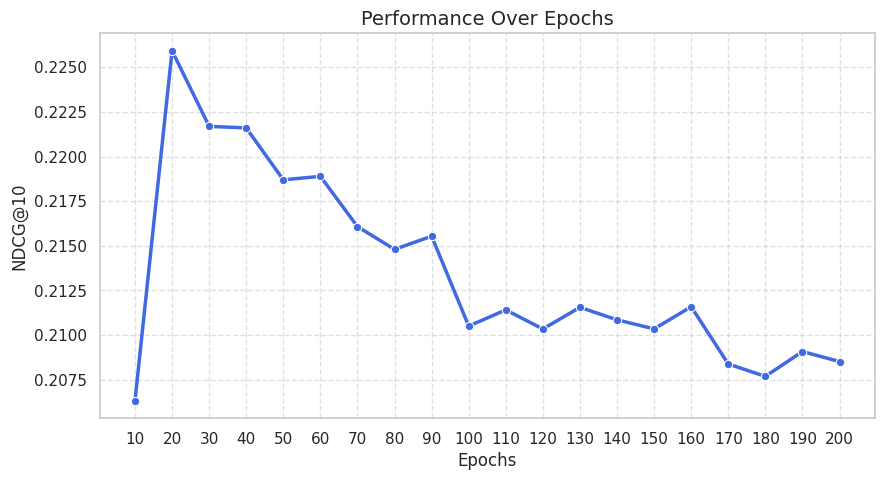

In [ ]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

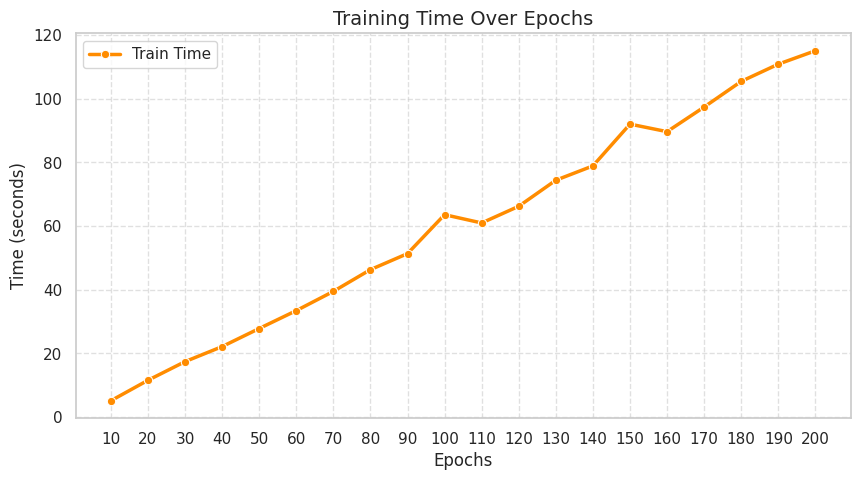

In [ ]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Epoch Parameter SVD

In [ ]:
epoch_result_svd = {}

In [ ]:
reader = Reader(rating_scale=(1, 10))
svd_train_set = Dataset.load_from_df(train_data_full[["user_id", "anime_id", "score"]], reader).build_full_trainset()

In [ ]:
for epoch in tqdm(range(10,210,10)):

  svd = surprise.SVD(random_state=SEED,
                         n_epochs=epoch,
                         verbose=False,
                         n_factors=200,
                         lr_all = 0.0045,
                         reg_all = 0.0014
                         )

  start_time = time.time()
  svd.fit(svd_train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions_svd = compute_ranking_predictions(
    svd, train_data_full, usercol="user_id", itemcol="anime_id", predcol="prediction", remove_seen=True
  )
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions_svd, col_user="user_id", col_item="anime_id", col_rating='score', k=10)
  epoch_result_svd[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
epoch_df = pd.DataFrame(epoch_result_svd).T.reset_index()

In [ ]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [ ]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.079164,10.796195,128.551556
1,20,0.077255,21.393925,119.152981
2,30,0.069547,30.985773,120.165354
3,40,0.064692,41.636817,116.997511
4,50,0.061840,59.078772,120.815357
5,60,0.059779,61.534297,118.127310
6,70,0.058361,73.808460,114.772264
7,80,0.056982,89.242627,122.548536
8,90,0.056069,92.737723,113.819727
9,100,0.055141,103.128291,125.548564


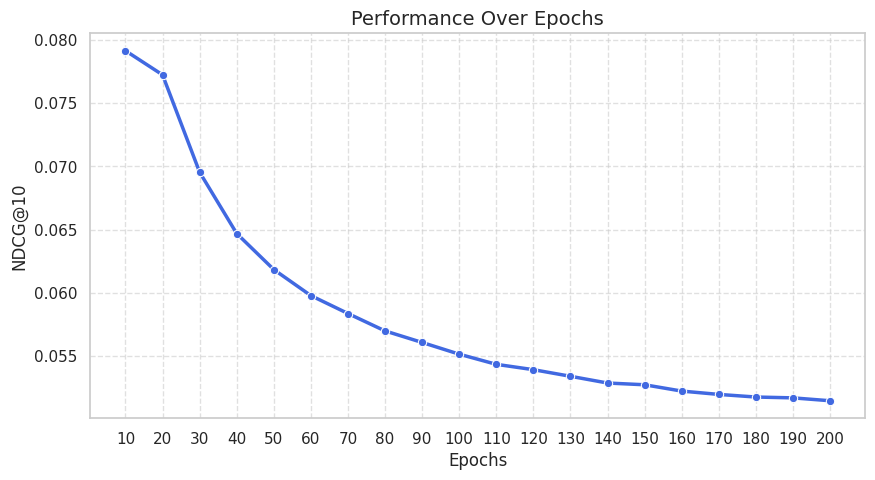

In [ ]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

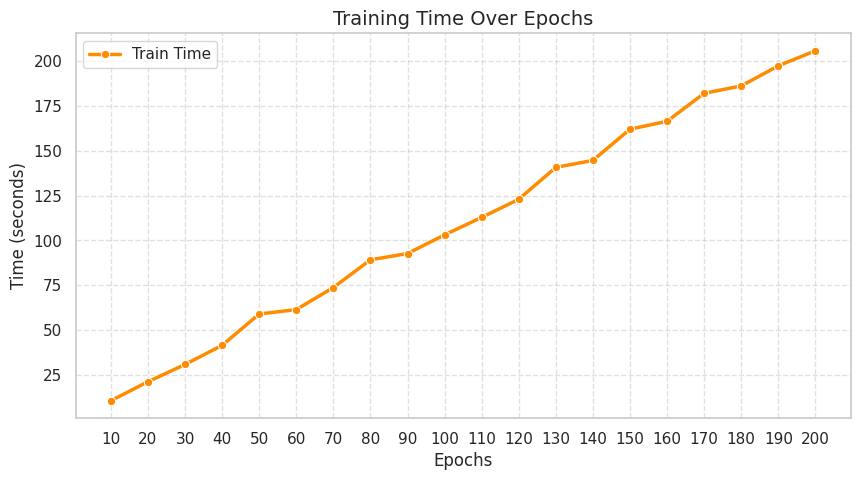

In [ ]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()